# TRACKING THE BICYCLE

We will track the bicycle using the measurements of the center of the detected Bounding Box.

We will download a video from the VIRAT Video Dataset:
*   *VIRAT_S_010204_09_001285_001336.mp4* is the original image from the [VIRAT Video Dataset](https://viratdata.org)

![alt text](https://raw.githubusercontent.com/Jeremy26/kalman_filters_course/master/images/screen_scene.png)

**About the dataset**
A Large-scale Benchmark Dataset for Event Recognition in Surveillance Video" by Sangmin Oh, Anthony Hoogs, Amitha Perera, Naresh Cuntoor, Chia-Chih Chen, Jong Taek Lee, Saurajit Mukherjee, J.K. Aggarwal, Hyungtae Lee, Larry Davis, Eran Swears, Xiaoyang Wang, Qiang Ji, Kishore Reddy, Mubarak Shah, Carl Vondrick, Hamed Pirsiavash, Deva Ramanan, Jenny Yuen, Antonio Torralba, Bi Song, Anesco Fong, Amit Roy-Chowdhury, and Mita Desai, in Proceedings of IEEE Comptuer Vision and Pattern Recognition (CVPR), 2011.
[Access Link](https://viratdata.org).

**About the project** <p>
We are given an image detection algorithm that isn't ideal. Sometimes, the algorithm fails and misses the target. These happen during occlusion or failures from the algorithm for various reasons.
Using a Kalman Filter is an effective way to keep track of the data; and that's exactly what we'll do!

**The goal of the project will be to use a Kalman Filter to continue tracking the pedestrian even when the detector fails.**


## Imports

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import copy
import pickle
import numpy as np
import time
import cv2

We have two videos at our disposal in the input_videos folder:
* **"detect.mp4"** showing you the detections on the surveillance camera
* **"VIRAT_S_010204_09_001285_001336"**, showing you the raw video.

We'll first visualize the detect video, and then work on improving the tracking.

In [2]:
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, video_width = 600):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

show_video("input_videos\detect.mp4")

<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Harshul\AppData\Local\Temp\ipykernel_15592\667633202.py:9: SyntaxWarning: invalid escape sequence '\d'
  show_video("input_videos\detect.mp4")


In [3]:
BICYCLE_MEASUREMENTS = [[264.0, 320.5], 'Not detected', [276.5, 324.0], [278.0, 323.5], [281.0, 322.5], [284.5, 323.5], [285.0, 324.0], [287.5, 324.0], [299.5, 326.5], [303.0, 327.0], [305.0, 326.5], [307.0, 327.0], [310.5, 326.5], [313.5, 323.5], [325.0, 323.5], [324.0, 326.5], [327.0, 327.0], [332.5, 327.0], [337.5, 323.5], [341.0, 324.0], [349.5, 325.5], [351.5, 325.5], [353.5, 325.0], [356.0, 325.0], [359.0, 325.0], [363.0, 325.0], [365.0, 322.5], [366.0, 322.5], [365.5, 322.0], [373.0, 325.5], [374.0, 325.0], [378.0, 324.5], [380.5, 323.5], [382.0, 323.5], [383.0, 324.0], [384.0, 323.0], [387.0, 322.0], [389.5, 322.0], [390.0, 321.5], [395.0, 324.0], [396.0, 322.5], [397.5, 323.5], [398.5, 323.0], [402.0, 322.5], [407.0, 336.0], [407.5, 335.5], [412.0, 336.0], [413.0, 336.5], [412.0, 339.5], [420.5, 337.0], [421.5, 336.0], [422.0, 336.0], [424.0, 336.0], [428.5, 336.5], [430.0, 337.0], [434.0, 337.5], [434.5, 337.0], [437.5, 336.5], [438.5, 336.0], 'Not detected', 'Not detected', [451.5, 336.5], [454.0, 336.5], 'Not detected', 'Not detected', [460.0, 336.5], 'Not detected', [462.5, 336.0], 'Not detected', 'Not detected', [473.0, 336.0], 'Not detected', 'Not detected', 'Not detected', [483.0, 335.5], 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', [527.5, 351.0], 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', [596.0, 381.0], [597.0, 365.0], [600.0, 380.0], [605.0, 380.0], [607.0, 381.0], [608.0, 381.0], [612.0, 380.0], [612.0, 380.0], [619.0, 383.0], [620.0, 382.5], [624.0, 392.0], [625.5, 392.0], [628.0, 380.5], [630.0, 393.5], [633.0, 393.0], [635.0, 394.0], [637.0, 394.0], [637.0, 395.0], [644.0, 397.0], [644.0, 397.0], [646.0, 395.5], [647.5, 394.5], [651.5, 393.5], 'Not detected', [655.0, 407.0], [656.0, 391.0], 'Not detected', 'Not detected', 'Not detected', 'Not detected', [669.0, 410.0], [669.0, 410.0], [673.0, 419.5], [675.0, 422.5], [679.5, 422.5], [680.5, 424.5], [683.0, 424.5], [685.0, 426.0], [686.0, 432.0], [695.0, 433.5], [694.5, 434.5], [696.5, 437.0], [700.0, 421.5], [700.0, 421.5], [705.0, 421.5], [708.0, 423.0], [709.0, 424.5], [712.5, 427.0], [715.0, 426.5], [716.0, 429.5], [718.5, 431.5], [722.0, 434.0], [724.5, 433.5], [725.0, 434.5], 'Not detected', 'Not detected', 'Not detected', [744.0, 466.0], [745.5, 453.0], [747.5, 455.0], [749.5, 453.5], [752.0, 455.0], [750.5, 457.0], 'Not detected', 'Not detected', 'Not detected', [761.0, 475.5], [761.0, 475.5], [762.5, 475.5], [764.0, 478.0], 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', [805.5, 537.0], [809.5, 536.5], [811.0, 536.5], [815.0, 538.0], 'Not detected', 'Not detected', [825.5, 563.0], 'Not detected', [842.5, 567.0], [844.5, 571.0], [845.5, 588.5], [852.0, 589.5], [857.0, 591.5], [864.0, 621.0], [868.0, 622.0], [874.0, 624.0], [891.0, 620.5], [891.0, 620.5], [897.5, 622.5], [909.0, 651.0], [919.5, 651.0], [928.0, 626.5], 'Not detected', [948.0, 648.5], [955.5, 647.0], [971.5, 641.0], [976.5, 678.0], [993.0, 682.0], [1008.5, 685.0], [1008.5, 685.0], [1018.5, 688.0], [1048.5, 687.5], 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected', 'Not detected']
TIMESTAMPS = [1595343383.4528093, 1595343385.1370091, 1595343386.7868967, 1595343388.4632287, 1595343390.1011188, 1595343391.7460542, 1595343393.39343, 1595343395.028878, 1595343396.6552625, 1595343398.311383, 1595343399.9449534, 1595343401.5756452, 1595343403.253039, 1595343404.8913975, 1595343406.5174625, 1595343408.1842604, 1595343409.8111398, 1595343411.4432359, 1595343413.068713, 1595343414.6940196, 1595343416.3461204, 1595343417.9728732, 1595343419.6360095, 1595343421.2727242, 1595343422.934089, 1595343424.5932963, 1595343426.2158902, 1595343427.882905, 1595343429.5383394, 1595343431.1689167, 1595343432.7992053, 1595343434.4365535, 1595343436.093556, 1595343437.739813, 1595343439.3699863, 1595343441.026304, 1595343442.6605077, 1595343444.2896566, 1595343445.9262085, 1595343447.5629303, 1595343449.1896112, 1595343450.838177, 1595343452.4649684, 1595343454.2198577, 1595343455.8605254, 1595343457.4931364, 1595343459.137956, 1595343460.8218405, 1595343462.4845269, 1595343464.1445982, 1595343465.8397083, 1595343467.4892106, 1595343469.1747668, 1595343470.8333223, 1595343472.5270133, 1595343474.1908607, 1595343475.8525598, 1595343477.520469, 1595343479.1996396, 1595343480.9057856, 1595343482.604339, 1595343484.2830782, 1595343485.9620562, 1595343487.6216116, 1595343489.285687, 1595343490.9448197, 1595343492.599015, 1595343494.262499, 1595343495.9328613, 1595343497.604377, 1595343499.2598104, 1595343500.919045, 1595343502.5755124, 1595343504.2685933, 1595343505.9388247, 1595343507.6111808, 1595343509.727008, 1595343512.6301236, 1595343515.2081826, 1595343516.8960044, 1595343518.562933, 1595343520.223518, 1595343521.8825817, 1595343523.5388012, 1595343525.2359374, 1595343526.9006064, 1595343528.5632, 1595343530.250608, 1595343531.9128368, 1595343533.5599396, 1595343535.2325077, 1595343536.8938165, 1595343538.5590377, 1595343540.213533, 1595343541.8728576, 1595343543.534645, 1595343545.2209647, 1595343546.886572, 1595343548.5626056, 1595343550.2205744, 1595343551.8829527, 1595343553.5659046, 1595343555.2469, 1595343556.9008927, 1595343558.5652347, 1595343560.2281246, 1595343561.8948984, 1595343563.5591393, 1595343565.215573, 1595343566.8824282, 1595343568.5690107, 1595343570.2471654, 1595343571.9168723, 1595343573.5790687, 1595343575.2646444, 1595343576.9260058, 1595343578.6006463, 1595343580.262466, 1595343581.9326503, 1595343583.6091404, 1595343585.3043597, 1595343586.98645, 1595343588.677084, 1595343590.3740606, 1595343592.2494593, 1595343594.0968316, 1595343595.9687498, 1595343597.7663443, 1595343599.5230067, 1595343601.2006478, 1595343602.8708787, 1595343604.5619361, 1595343606.240997, 1595343607.9550593, 1595343609.640338, 1595343611.3281717, 1595343612.9923398, 1595343614.6791606, 1595343616.3586695, 1595343618.03751, 1595343619.7365143, 1595343621.4086063, 1595343623.0755863, 1595343624.7747118, 1595343626.4529173, 1595343628.1450953, 1595343629.8409429, 1595343631.5103605, 1595343633.2032287, 1595343634.8988585, 1595343636.5533113, 1595343638.2447634, 1595343639.9315574, 1595343641.6105409, 1595343643.3112786, 1595343644.9819617, 1595343646.6454144, 1595343648.3410013, 1595343650.0291924, 1595343651.7229924, 1595343653.4247396, 1595343655.0940385, 1595343656.766598, 1595343658.481635, 1595343660.1688697, 1595343661.851529, 1595343663.533179, 1595343665.2161155, 1595343666.9030716, 1595343668.6122663, 1595343670.3100102, 1595343671.9878461, 1595343673.6751158, 1595343675.361766, 1595343677.0522666, 1595343678.7405472, 1595343680.4148567, 1595343682.0903854, 1595343683.766348, 1595343685.4356513, 1595343687.1099372, 1595343688.82005, 1595343690.4986932, 1595343692.191855, 1595343693.8794398, 1595343695.5785794, 1595343697.2438045, 1595343698.998921, 1595343700.696096, 1595343702.375422, 1595343704.0798686, 1595343705.765661, 1595343707.4556317, 1595343709.2128184, 1595343710.8825693, 1595343712.5990374, 1595343714.2921202, 1595343715.9963896, 1595343717.6725974, 1595343719.3480031, 1595343721.0423503, 1595343722.7256033, 1595343724.4065895, 1595343726.0711443, 1595343727.7579536, 1595343729.4652514, 1595343731.1564894, 1595343732.8382416, 1595343734.516435, 1595343736.182922, 1595343737.882777, 1595343739.5695834, 1595343741.241596, 1595343742.9077015, 1595343744.5780733, 1595343746.2444737, 1595343747.9014044, 1595343749.56856, 1595343751.2365348, 1595343752.9167588, 1595343754.582135, 1595343756.2607112, 1595343757.9484925, 1595343759.6065814, 1595343761.2696397, 1595343762.9366505, 1595343764.5937672, 1595343766.266156, 1595343767.931009, 1595343769.606072, 1595343771.286105, 1595343772.9624963, 1595343774.622179, 1595343776.2862227, 1595343777.9396627, 1595343779.597795, 1595343781.266818, 1595343782.9147005, 1595343784.5958788, 1595343786.2695682, 1595343787.937123]

In [4]:
print(BICYCLE_MEASUREMENTS)
print(len(BICYCLE_MEASUREMENTS))
print(TIMESTAMPS)
print(len(TIMESTAMPS))

[[264.0, 320.5], 'Not detected', [276.5, 324.0], [278.0, 323.5], [281.0, 322.5], [284.5, 323.5], [285.0, 324.0], [287.5, 324.0], [299.5, 326.5], [303.0, 327.0], [305.0, 326.5], [307.0, 327.0], [310.5, 326.5], [313.5, 323.5], [325.0, 323.5], [324.0, 326.5], [327.0, 327.0], [332.5, 327.0], [337.5, 323.5], [341.0, 324.0], [349.5, 325.5], [351.5, 325.5], [353.5, 325.0], [356.0, 325.0], [359.0, 325.0], [363.0, 325.0], [365.0, 322.5], [366.0, 322.5], [365.5, 322.0], [373.0, 325.5], [374.0, 325.0], [378.0, 324.5], [380.5, 323.5], [382.0, 323.5], [383.0, 324.0], [384.0, 323.0], [387.0, 322.0], [389.5, 322.0], [390.0, 321.5], [395.0, 324.0], [396.0, 322.5], [397.5, 323.5], [398.5, 323.0], [402.0, 322.5], [407.0, 336.0], [407.5, 335.5], [412.0, 336.0], [413.0, 336.5], [412.0, 339.5], [420.5, 337.0], [421.5, 336.0], [422.0, 336.0], [424.0, 336.0], [428.5, 336.5], [430.0, 337.0], [434.0, 337.5], [434.5, 337.0], [437.5, 336.5], [438.5, 336.0], 'Not detected', 'Not detected', [451.5, 336.5], [454.0,

## Design the Kalman Filter

**These are the questions we will focus on:**
*   How will the mean and covariance be initialize?
*   How will we initialize the other matrices?
*   What happens when nothing is detected?
*   What happens during a detection?
*   What Process Model (F) will you use?

# Step 2 - Implement the Filter


In [5]:
!pip install filterpy

     ---------------------------------------- 0.0/178.0 kB ? eta -:--:--
     ---- -------------------------------- 20.5/178.0 kB 330.3 kB/s eta 0:00:01
     -------------------------------------- 178.0/178.0 kB 2.2 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/f5/6f/e6e5aff77ea2a48dd96808bb51d7450875af154ee7cbe72188afb0b37929/scipy-1.15.2-cp312-cp312-win_amd64.whl.metadata
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 60.8/60.8 kB ? eta 0:00:00
   ---------------------------------------- 0.0/40.9 MB ? eta -:--:--
    -------------


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
from filterpy.kalman import KalmanFilter
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise
import numpy as np
import matplotlib.pyplot as plt

def TwoDimensionsKF(R_std, Q_std, dt):
    """ Create first order Kalman filter.
    Specify R and Q as floats."""
    kf = KalmanFilter(dim_x=4, dim_z=2)
    kf.P = np.eye(4)*500
    kf.R = np.eye(2) * R_std**2
    q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_std**2)
    kf.Q = block_diag(q, q)
    kf.F = np.array([[1, dt, 0,  0],
                    [0,  1, 0,  0],
                    [0,  0, 1, dt],
                    [0,  0, 0,  1]])

    kf.H = np.array([[1, 0, 0, 0],
                    [0, 0, 1, 0]])
    return kf

In [7]:
print(sum(np.diff(TIMESTAMPS))/len(TIMESTAMPS))

print(TIMESTAMPS[1] - TIMESTAMPS[0])

1.6783581482424281
1.6841998100280762


In [8]:
kf = TwoDimensionsKF(R_std=5, Q_std=0.01, dt=sum(np.diff(TIMESTAMPS))/len(TIMESTAMPS))
kf.x = np.array([BICYCLE_MEASUREMENTS[0][0], 0, BICYCLE_MEASUREMENTS[0][1], 0])

In [19]:
counter = 0

def main_pipeline(image):
    global kf
    global counter
    meas = BICYCLE_MEASUREMENTS[counter] # SIMULATES THE DETECTOR
    #When the detector don't detect anything
    if meas == "Not detected":
        kf.predict()
        cv2.circle(image, (int(kf.x_prior[0]), int(kf.x_prior[2])), 5, (255,0,0), -1)

    #When the detector detects something
    else:
        z = np.array((meas[0], meas[1]))
        kf.update(z)
        cv2.circle(image, (int(kf.x[0]), int(kf.x[2])), 5, (78,200,120), -1)
        kf.predict()
        cv2.circle(image, (int(kf.x_prior[0]), int(kf.x_prior[2])), 5, (200,50,78), -1)
    counter+=1
    return image

In [21]:
cam = cv2.VideoCapture("input_videos/detect.mp4")

set_of_images = []
while(True):
    ret,frame = cam.read()
    if ret:
        set_of_images.append(frame)
    else:
        break

cam.release()
cv2.destroyAllWindows()

In [22]:
out_video = []

for img in set_of_images:
    out_video.append(main_pipeline(img))

In [23]:
print(out_video[0].shape)

(720, 1280, 3)


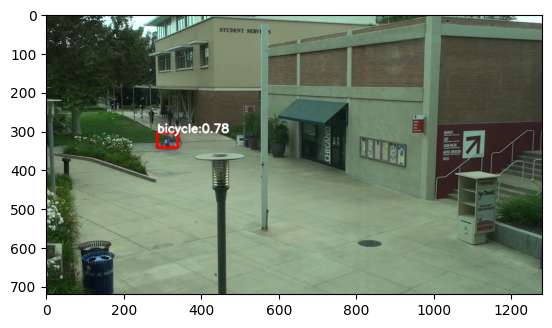

In [24]:
plt.imshow(cv2.cvtColor(out_video[12], cv2.COLOR_BGR2RGB))

In [25]:
out = cv2.VideoWriter("track.mp4",cv2.VideoWriter_fourcc(*'MP4V'), 20, (1280,720))

for i in range(len(out_video)):
    out.write(out_video[i])
out.release()

In [26]:
show_video("track.mp4")